In [1]:
import matplotlib as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (13, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important;} </style>"))

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import json
import copy
import time
import argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

from data.dataloader import get_train_dataloader, get_valid_dataloader
from train import train_model, get_resnet, get_team_predictions

### Set parameters from config

In [2]:
config_path = './config.json'
config = json.load(open(config_path, "r"))
game_img_path = config["paths"]["game_image_path"]
champion_folder = config["paths"]["champion_folder"]

num_classes = len(os.listdir(champion_folder))
num_epochs = config["dl"]["epochs"]
learning_rate = config["dl"]["learning_rate"]
momentum = config["dl"]["momentum"]
batch_size = config["dl"]["batch_size"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Crop the background image

Use this to add noise for the training and to obtain more training samples.

In [4]:
# crop the background image from the game screenshot
game = cv2.imread(game_img_path, cv2.IMREAD_COLOR)
background = game[90:-300, 80:-90, :]


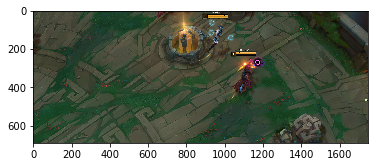

In [6]:
plt.imshow(background)
plt.show()

### Get the training and validation dataloaders

In [7]:
# get dataloaders
train_dataloader, encoder = get_train_dataloader(
    champion_folder,
    background,
    output_size=65,
    object_size=(35, 45),
    batch_size=batch_size,
    shuffle=True,
)
valid_dataloader, _ = get_valid_dataloader(
    encoder,
    data_path=game_img_path,
    team="right",
    batch_size=batch_size,
    shuffle=True,
)

dataloaders = {}
dataloaders["train"] = train_dataloader
dataloaders["valid"] = valid_dataloader


### Obtain the Resnet-18 model that is pretrained on ImageNet

Update the parameters of the last layer.

In [8]:
# get Resnet-18 model
model, params_to_update = get_resnet(num_classes, device)
# optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(params_to_update, lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train Resnet-18

In [10]:
# train model
model, _ = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=num_epochs, device=device
)


Epoch 1/50
----------


/home/oyku/anaconda3/envs/image_env/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train - Loss: 7.1540 	 Acc: 0.0000
valid - Loss: 6.0542 	 Acc: 0.0000

Epoch 2/50
----------
train - Loss: 5.2838 	 Acc: 0.0135
valid - Loss: 5.3926 	 Acc: 0.0000

Epoch 3/50
----------
train - Loss: 4.4281 	 Acc: 0.0608
valid - Loss: 4.9335 	 Acc: 0.0000

Epoch 4/50
----------
train - Loss: 3.9246 	 Acc: 0.1486
valid - Loss: 4.1946 	 Acc: 0.4000

Epoch 5/50
----------
train - Loss: 3.6573 	 Acc: 0.1622
valid - Loss: 4.8656 	 Acc: 0.2000

Epoch 6/50
----------
train - Loss: 3.1955 	 Acc: 0.2297
valid - Loss: 5.0485 	 Acc: 0.2000

Epoch 7/50
----------
train - Loss: 2.9909 	 Acc: 0.3514
valid - Loss: 3.1992 	 Acc: 0.2000

Epoch 8/50
----------
train - Loss: 2.9248 	 Acc: 0.3784
valid - Loss: 4.3156 	 Acc: 0.2000

Epoch 9/50
----------
train - Loss: 2.8446 	 Acc: 0.3446
valid - Loss: 2.4889 	 Acc: 0.2000

Epoch 10/50
----------
train - Loss: 2.5491 	 Acc: 0.4054
valid - Loss: 4.3393 	 Acc: 0.2000

Epoch 11/50
----------
train - Loss: 2.3287 	 Acc: 0.4527
valid - Loss: 3.3095 	 Acc: 0.400

### Predict champions of both teams

In [11]:
# get team predictions
left_dataloader, left_true_labels = get_valid_dataloader(
    encoder, data_path=game_img_path, team="left", batch_size=1, shuffle=False
)
right_dataloader, right_true_labels = get_valid_dataloader(
    encoder, data_path=game_img_path, team="right", batch_size=1, shuffle=False
)
left_players = get_team_predictions(model, left_dataloader, encoder)
right_players = get_team_predictions(model, right_dataloader, encoder)

print("Left team members are predicted as: \n {}\n".format(left_players))
print("Actual feft team members are: \n {}\n\n".format(left_true_labels))
print("Right team members are predicted as: \n {}\n".format(right_players))
print("Actual right team members are: \n {}\n".format(right_true_labels))


Left team members are predicted as: 
 ['Ornn', 'Lucian', 'Syndra', 'Syndra', 'Thresh']

Actual feft team members are: 
 ['Ornn', 'RekSai', 'Syndra', 'Aphelios', 'Thresh']


Right team members are predicted as: 
 ['Fizz', 'LeeSin', 'Yasuo', 'Cassiopeia', 'Fizz']

Actual right team members are: 
 ['Jax', 'LeeSin', 'Yasuo', 'Cassiopeia', 'Blitzcrank']

